<a href="https://colab.research.google.com/github/marreapato/Deep_Learning_Course/blob/main/Reading_MIT_Indoor_Scene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Fri Sep 29 16:19:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Baixando os Dados e incluindo no Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Fundamentals_Deep_Learning

!ls




/content/gdrive/.shortcut-targets-by-id/1RQft65Bgd2d6TCEfL0c3FLA4gzbYIqmV/Fundamentals_Deep_Learning
 001_tensorflow.ipynb		     activities.csv
 00_jupyterlab.ipynb		     asl_model
 01_mnist.ipynb			     BANKEX.csv
 02_asl.ipynb			    'Cópia de 01_mnist.ipynb'
 03_asl_cnn.ipynb		     data
 04a_asl_augmentation.ipynb	     images
 04b_asl_predictions.ipynb	     mit_indoor_scene_dataset
 05a_doggy_door.ipynb		    'NN FeedForward - CIFAR - 10.ipynb'
 05b_presidential_doggy_door.ipynb   outdir
 06_headline_generator.ipynb	     RNN_multi.ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import os

# Define the URL of the dataset
url = "http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar"

# Define the directory where you want to save the dataset
save_dir = "/content/gdrive/MyDrive/Fundamentals_Deep_Learning/mit_indoor_scene_dataset"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define the path where you want to save the downloaded file
save_path = os.path.join(save_dir, "indoorCVPR_09.tar.gz")

# Send an HTTP GET request to download the dataset
response = requests.get(url, stream=True)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Open the file in binary write mode and write the content of the response
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)

    print(f"Downloaded the dataset to {save_path}")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")

# You can now extract the contents of the downloaded tar.gz file using Python's tarfile module if needed.


Downloaded the dataset to /content/gdrive/MyDrive/Fundamentals_Deep_Learning/mit_indoor_scene_dataset/indoorCVPR_09.tar.gz


In [5]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For separating train and test sets
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import numpy as np
import pathlib

In [ ]:
from PIL import Image
import os
import tarfile
import os

# Define the path to an example image
image_path = "/content/gdrive/MyDrive/Fundamentals_Deep_Learning/mit_indoor_scene_dataset/indoorCVPR_09.tar.gz"



t = tarfile.open(image_path, 'r')
for member in t.getmembers():
    if ".jpg" in member.name:
        t.extract(member, "outdir")

print(os.listdir('outdir'))

# Leitura dos Dados

In [6]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set the path to your dataset directory
dataset_dir = '/content/gdrive/MyDrive/Fundamentals_Deep_Learning/outdir/Images'

# Create an instance of the ImageFolder dataset
dataset = ImageFolder(root=dataset_dir, transform=transform)

# Define the percentage of data to use for testing
test_split = 0.25  # 25% for testing

# Calculate the size of the testing set
test_size = int(test_split * len(dataset))
train_size = len(dataset) - test_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the number of samples in the training and testing sets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# You can now use train_dataloader and test_dataloader to iterate through your data in batches for training and testing.
# Your training and evaluation code goes here.


Number of training samples: 11710
Number of testing samples: 3903


In [ ]:
dataset.class_to_idx

{'airport_inside': 0,
 'artstudio': 1,
 'auditorium': 2,
 'bakery': 3,
 'bar': 4,
 'bathroom': 5,
 'bedroom': 6,
 'bookstore': 7,
 'bowling': 8,
 'buffet': 9,
 'casino': 10,
 'children_room': 11,
 'church_inside': 12,
 'classroom': 13,
 'cloister': 14,
 'closet': 15,
 'clothingstore': 16,
 'computerroom': 17,
 'concert_hall': 18,
 'corridor': 19,
 'deli': 20,
 'dentaloffice': 21,
 'dining_room': 22,
 'elevator': 23,
 'fastfood_restaurant': 24,
 'florist': 25,
 'gameroom': 26,
 'garage': 27,
 'greenhouse': 28,
 'grocerystore': 29,
 'gym': 30,
 'hairsalon': 31,
 'hospitalroom': 32,
 'inside_bus': 33,
 'inside_subway': 34,
 'jewelleryshop': 35,
 'kindergarden': 36,
 'kitchen': 37,
 'laboratorywet': 38,
 'laundromat': 39,
 'library': 40,
 'livingroom': 41,
 'lobby': 42,
 'locker_room': 43,
 'mall': 44,
 'meeting_room': 45,
 'movietheater': 46,
 'museum': 47,
 'nursery': 48,
 'office': 49,
 'operating_room': 50,
 'pantry': 51,
 'poolinside': 52,
 'prisoncell': 53,
 'restaurant': 54,
 'resta

# Construção do Gráfico de Barras por Split

In [ ]:
# Get the first batch (you can change this to any batch you want to inspect)

label_to_count=[]

for i in range(0,600):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(600,1200):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(1200,1800):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(1800,2400):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(2400,3000):

  label_to_count.append(train_dataset[i][1])
  print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
for i in range(3000,3600):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(3600,4200):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(4200,4800):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(4800,5400):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(5400,6000):

  label_to_count.append(train_dataset[i][1])
  print(i)


3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199


In [ ]:
for i in range(6000,6600):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(6600,7200):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(7200,7800):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(7800,8400):

  label_to_count.append(train_dataset[i][1])
  print(i)

for i in range(8400,9000):

  label_to_count.append(train_dataset[i][1])
  print(i)


6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199


In [ ]:
for i in range(9000,len(train_dataset)):

  label_to_count.append(train_dataset[i][1])
  print(i)


9000
9001
9002
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9015
9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105
9106
9107
9108
9109
9110
9111
9112
9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199


In [ ]:
len(label_to_count)==len(train_dataset)

True

In [ ]:
# Your NumPy array of integers
my_array = np.array(label_to_count)  # Example codes for 'A', 'B', 'C'

# Convert integers to strings using NumPy's vectorized operations
string_array = my_array.astype(str)

# Now, 'string_array' contains the elements as strings
print(string_array)

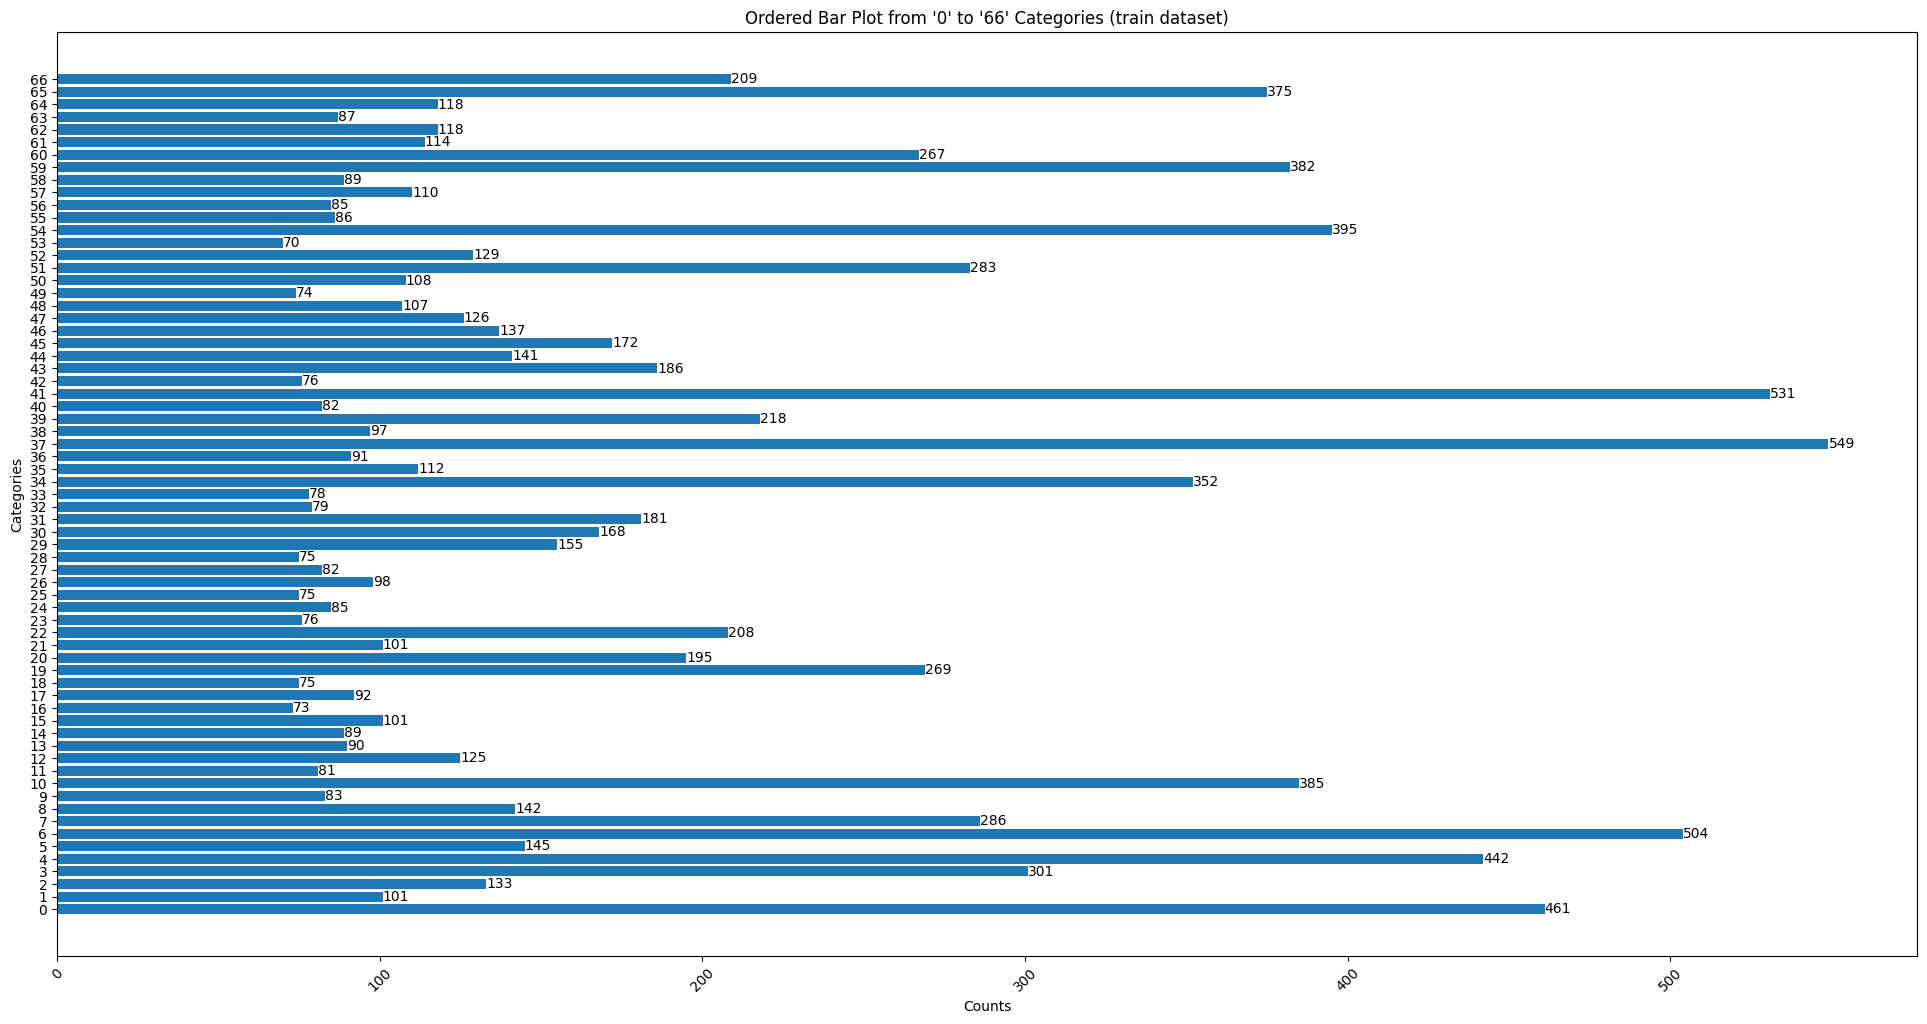

In [ ]:
from collections import Counter

# Count the occurrences of each category using Counter
category_counts = Counter(string_array)

# Separate the categories and their counts
categories = list(category_counts.keys())
counts = list(category_counts.values())

# Define the desired order for the categories (ascending order)
desired_order = [str(i) for i in range(67)]

# Create a larger figure (adjust the figure size as needed)
plt.figure(figsize=(24, 12))

# Create a horizontal bar plot with ordered categories
bars = plt.barh(desired_order, [category_counts[category] for category in desired_order])

# Add labels and a title
plt.xlabel("Counts")
plt.ylabel("Categories")
plt.title("Ordered Bar Plot from '0' to '66' Categories (train dataset)")

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)

# Add labels on top of each bar
for bar, count in zip(bars, [category_counts[category] for category in desired_order]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(count), ha='left', va='center')

# Rotate x-axis labels (adjust the angle as needed)
plt.xticks(rotation=45)  # Rotate labels by 45 degrees

# Show the plot
plt.show()








In [ ]:
counts[11]

98

In [ ]:
categories

['62',
 '23',
 '47',
 '41',
 '8',
 '11',
 '52',
 '43',
 '1',
 '34',
 '60',
 '26',
 '31',
 '37',
 '59',
 '65',
 '56',
 '4',
 '7',
 '3',
 '51',
 '39',
 '64',
 '38',
 '48',
 '27',
 '10',
 '0',
 '15',
 '30',
 '19',
 '29',
 '66',
 '9',
 '54',
 '53',
 '35',
 '14',
 '20',
 '21',
 '16',
 '61',
 '6',
 '5',
 '44',
 '45',
 '58',
 '32',
 '18',
 '24',
 '55',
 '17',
 '13',
 '28',
 '46',
 '12',
 '40',
 '49',
 '57',
 '63',
 '22',
 '50',
 '25',
 '2',
 '36',
 '42',
 '33']

In [ ]:
label_to_count_test=[]

for i in range(0,len(test_dataset)):

  label_to_count_test.append(test_dataset[i][1])
  print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Your NumPy array of integers
my_array_test = np.array(label_to_count_test)  # Example codes for 'A', 'B', 'C'

# Convert integers to strings using NumPy's vectorized operations
string_array_test = my_array_test.astype(str)

# Now, 'string_array' contains the elements as strings
print(string_array_test)

['51' '11' '27' ... '40' '37' '4']


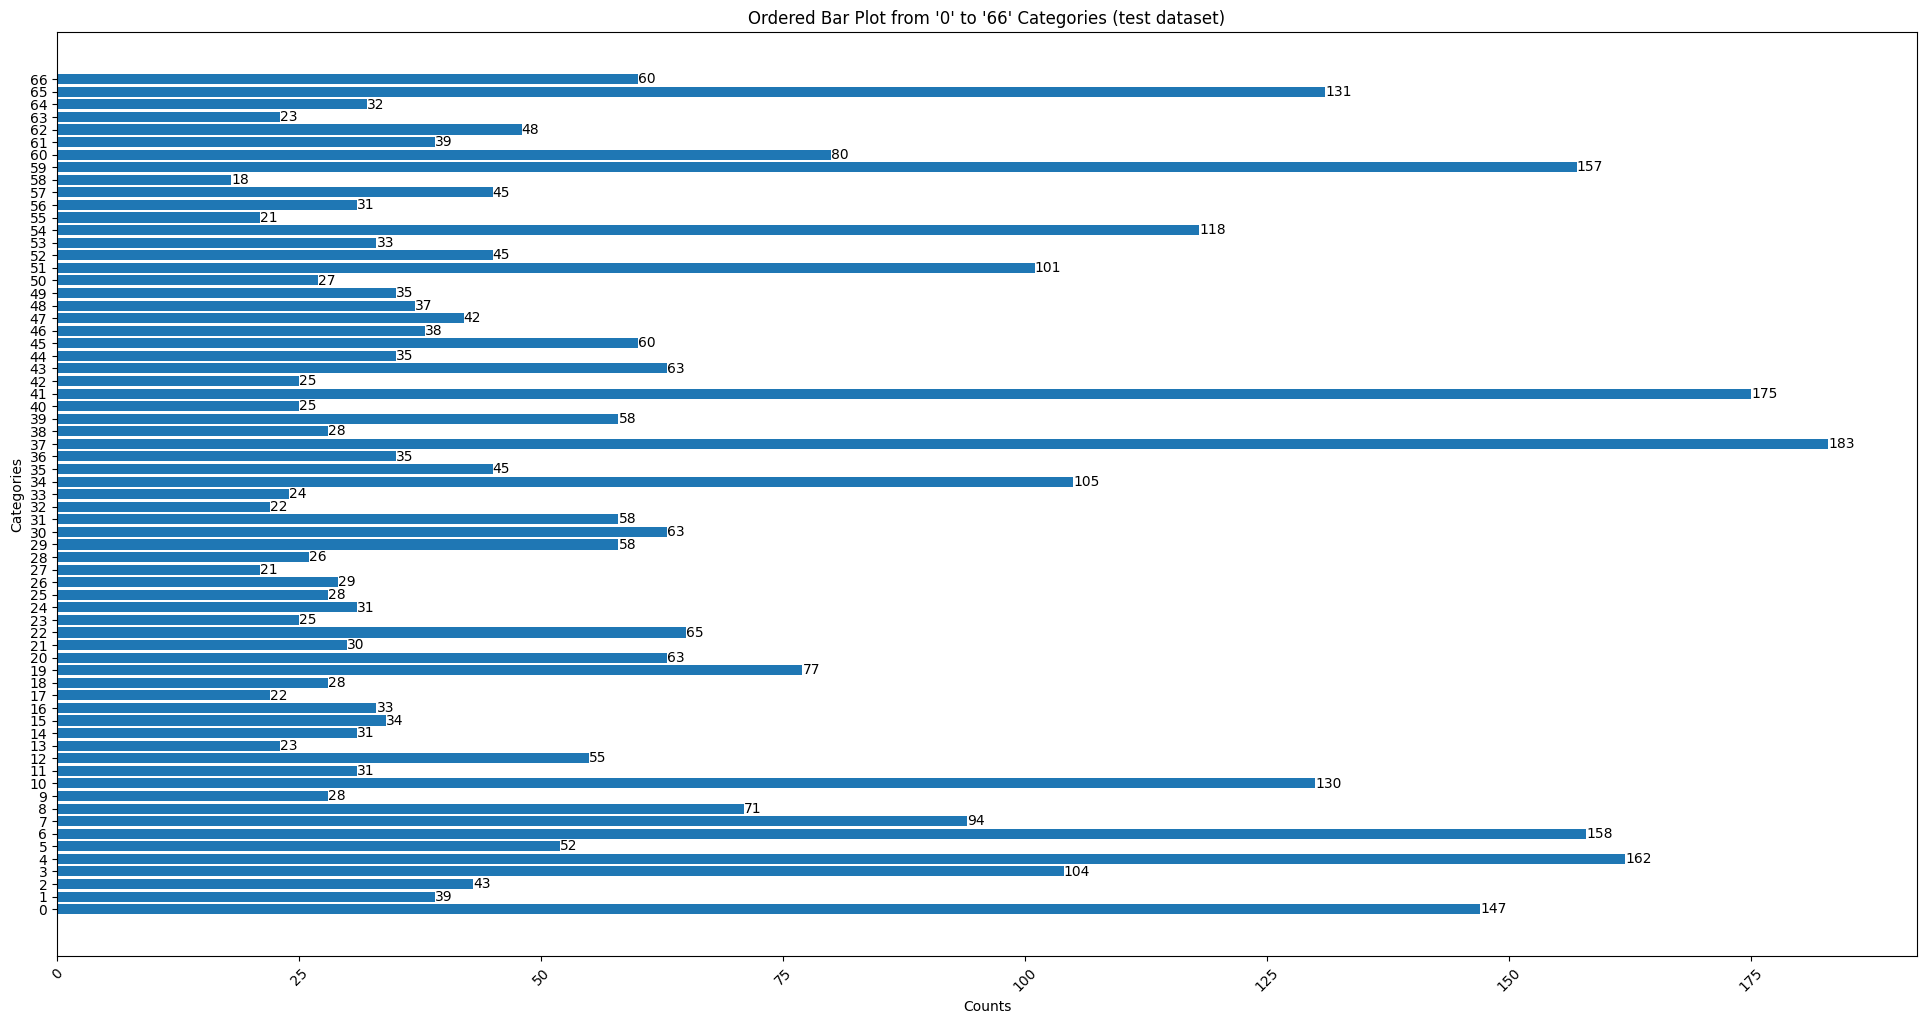

In [ ]:
from collections import Counter

# Count the occurrences of each category using Counter
category_counts_test = Counter(string_array_test)

# Separate the categories and their counts
categories = list(category_counts_test.keys())
counts = list(category_counts_test.values())

# Define the desired order for the categories (ascending order)
desired_order = [str(i) for i in range(67)]

# Create a larger figure (adjust the figure size as needed)
plt.figure(figsize=(24, 12))

# Create a horizontal bar plot with ordered categories
bars = plt.barh(desired_order, [category_counts_test[category] for category in desired_order])

# Add labels and a title
plt.xlabel("Counts")
plt.ylabel("Categories")
plt.title("Ordered Bar Plot from '0' to '66' Categories (test dataset)")

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)

# Add labels on top of each bar
for bar, count in zip(bars, [category_counts_test[category] for category in desired_order]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(count), ha='left', va='center')

# Rotate x-axis labels (adjust the angle as needed)
plt.xticks(rotation=45)  # Rotate labels by 45 degrees

# Show the plot
plt.show()








# Modelo

In [7]:
import torch

torch.__version__

'2.0.1+cu118'

In [8]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.2 MB/s eta 0:00:00


In [9]:
import timm

In [10]:
model = timm.create_model('resnet34', pretrained=True, num_classes=67)
x     = torch.randn(1, 3, 224, 224)
model(x).shape

torch.Size([1, 67])

In [11]:
model.forward_features(x).shape

torch.Size([1, 512, 7, 7])

In [12]:
model.pretrained_cfg# architecture of the model matches chosen architeture in the beggining (torch architecture)

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet34_a1_0-46f8f793.pth',
 'hf_hub_id': 'timm/resnet34.a1_in1k',
 'architecture': 'resnet34',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

# Avaliação do Modelo

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from tqdm.notebook import tqdm

def evaluate(dataloader, model):
  model.cuda()
  model.eval()

  targets = []
  all_preds = []

  for x, y in tqdm(dataloader):
    logits = model(x.cuda())
    pred = logits.argmax(1).flatten().cpu().tolist()

    targets.extend(y.cpu().tolist())
    all_preds.extend(pred)

  acc = accuracy_score(y_true=targets, y_pred=all_preds)
  cm = confusion_matrix(y_true=targets, y_pred=all_preds)
  f1 = f1_score(y_true=targets, y_pred=all_preds, average='weighted')

  return acc, cm, f1

evaluate(test_dataloader, model)

  0%|          | 0/122 [00:00<?, ?it/s]

(0.010760953112990008,
 array([[0, 0, 6, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 1]]),
 0.0038775921639632636)

# Avaliação da acurácia de treinamento

In [14]:
evaluate(train_dataloader, model)

  0%|          | 0/366 [00:00<?, ?it/s]

(0.012809564474807857,
 array([[ 0,  1, 25, ...,  0,  0,  0],
        [ 0,  0,  8, ...,  0,  0,  0],
        [ 0,  0,  1, ...,  0,  0,  0],
        ...,
        [ 0,  0,  2, ...,  0,  0,  0],
        [ 0,  0,  9, ...,  0,  0,  0],
        [ 0,  0,  4, ...,  0,  0,  1]]),
 0.00334467243888751)

# Épocas

In [15]:
def epoch(dataloader, model, criterion, optimizer):
  model.cuda()
  model.train()

  epoch_loss = 0.0
  num_batches = 0

  for x, y in tqdm(dataloader):
    # erase the current model gradients
    optimizer.zero_grad()

    # forward
    logits = model(x.cuda())
    loss = criterion(input=logits, target=y.cuda())

    # backward
    loss.backward()

    # weights update ~ w = w_cur - lr*grad(loss, w)
    optimizer.step()

    epoch_loss += loss.detach().cpu().item()
    num_batches += 1

  return epoch_loss/num_batches

# Pipeline + Avaliação das Acurácias de Treinamento

In [16]:
summary = {
    'model_state':None,
    'f1_history':[],
    'acc_history':[],
    'cm_history':[],
    'train_loss_history':[],
    'train_acc_history': []
}

lr = 1e-3
num_epochs = 10
best_acc = 0.0

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss(weight=None)


for e in range(num_epochs):
  print('Epoch:', e)
  cur_loss = epoch(train_dataloader, model, criterion, optimizer)

  # Calculate training accuracy
  train_acc, train_cm, train_f1 = evaluate(train_dataloader, model)#gets only train_acc

  test_acc, test_cm, test_f1 = evaluate(test_dataloader, model)

  summary['f1_history'].append(test_f1)
  summary['acc_history'].append(test_acc)
  summary['cm_history'].append(test_cm)
  summary['train_loss_history'].append(cur_loss)
  summary['train_acc_history'].append(train_acc)

  if test_acc > best_acc:
    summary['model_state'] = model.state_dict()
    best_acc = test_acc

  print('\t Training loss:', train_acc)
  print('\t Training accuracy:', test_f1)
  print('\t Test accuracy:', test_acc)
  print('\t Test confusion-matrix:', test_cm)
  print('\t Test F1:', test_f1)
  print()

summary_path = '/content/gdrive/MyDrive/Fundamentals_Deep_Learning/mit_indoor_scene_dataset/summary.pth'

torch.save(summary, summary_path)

Epoch: 0


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

	 Training loss: 0.6855678906917165
	 Training accuracy: 0.5846924793120531
	 Test accuracy: 0.6049192928516526
	 Test confusion-matrix: [[ 91   0   0 ...   0   2   0]
 [  1   7   0 ...   0   1   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   6   1   0]
 [ 10   0   0 ...   0 100   2]
 [  3   0   0 ...   0   1  40]]
	 Test F1: 0.5846924793120531

Epoch: 1


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

	 Training loss: 0.866865926558497
	 Training accuracy: 0.6843705693220379
	 Test accuracy: 0.6858826543684345
	 Test confusion-matrix: [[81  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  1  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 1  0  0 ... 17  1  0]
 [ 5  0  2 ...  0 95  0]
 [ 1  0  2 ...  0  2 44]]
	 Test F1: 0.6843705693220379

Epoch: 2


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

	 Training loss: 0.9148590947907771
	 Training accuracy: 0.6891964199412735
	 Test accuracy: 0.6920317704330002
	 Test confusion-matrix: [[110   0   0 ...   1   0   0]
 [  0  17   0 ...   0   0   0]
 [  0   0  28 ...   0   0   0]
 ...
 [  0   0   0 ...  11   0   0]
 [  4   0   0 ...   0 106   1]
 [  0   0   3 ...   0   2  49]]
	 Test F1: 0.6891964199412735

Epoch: 3


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

	 Training loss: 0.9543125533731853
	 Training accuracy: 0.7080460175835088
	 Test accuracy: 0.7084294132718422
	 Test confusion-matrix: [[105   0   0 ...   1   3   0]
 [  1  14   0 ...   0   1   0]
 [  2   0  26 ...   0   0   0]
 ...
 [  0   0   0 ...  16   0   0]
 [  4   0   0 ...   0 105   1]
 [  0   0   0 ...   0   2  44]]
	 Test F1: 0.7080460175835088

Epoch: 4


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

	 Training loss: 0.9700256191289496
	 Training accuracy: 0.7047215024684378
	 Test accuracy: 0.7074045605944146
	 Test confusion-matrix: [[109   0   0 ...   1   2   0]
 [  1  16   0 ...   0   1   0]
 [  1   0  12 ...   0   0   0]
 ...
 [  0   0   0 ...  18   0   0]
 [  5   0   0 ...   0 101   1]
 [  1   0   2 ...   0   2  48]]
	 Test F1: 0.7047215024684378

Epoch: 5


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

	 Training loss: 0.9798462852263023
	 Training accuracy: 0.7150661619616161
	 Test accuracy: 0.71688444786062
	 Test confusion-matrix: [[ 88   0   0 ...   0   4   0]
 [  0  17   0 ...   0   0   0]
 [  0   0  17 ...   0   0   1]
 ...
 [  1   0   0 ...  16   0   0]
 [  2   0   0 ...   0 104   0]
 [  0   0   0 ...   0   2  45]]
	 Test F1: 0.7150661619616161

Epoch: 6


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

	 Training loss: 0.9664389410760034
	 Training accuracy: 0.6913293098455187
	 Test accuracy: 0.692800409941071
	 Test confusion-matrix: [[98  0  1 ...  0  4  0]
 [ 0 17  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 1  0  0 ... 15  0  0]
 [ 3  0  1 ...  0 95  0]
 [ 1  0  0 ...  0  3 47]]
	 Test F1: 0.6913293098455187

Epoch: 7


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

	 Training loss: 0.9698548249359522
	 Training accuracy: 0.6928075230205655
	 Test accuracy: 0.692800409941071
	 Test confusion-matrix: [[108   0   1 ...   1   5   0]
 [  2   2   0 ...   2   1   0]
 [  0   0  31 ...   0   0   0]
 ...
 [  0   0   0 ...  23   0   0]
 [  4   0   1 ...   2  94   2]
 [  0   0   0 ...   0   2  52]]
	 Test F1: 0.6928075230205655

Epoch: 8


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

	 Training loss: 0.9814688300597779
	 Training accuracy: 0.7073265536872487
	 Test accuracy: 0.7107353317960543
	 Test confusion-matrix: [[109   0   0 ...   2   2   0]
 [  0  14   0 ...   1   1   0]
 [  1   0  25 ...   0   0   0]
 ...
 [  0   0   0 ...  23   0   0]
 [  7   0   0 ...   0 101   1]
 [  0   0   1 ...   0   2  46]]
	 Test F1: 0.7073265536872487

Epoch: 9


  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

	 Training loss: 0.9839453458582408
	 Training accuracy: 0.698667025508258
	 Test accuracy: 0.6984370996669229
	 Test confusion-matrix: [[ 83   0   0 ...   1   3   0]
 [  0  15   0 ...   0   0   0]
 [  1   0  29 ...   0   1   0]
 ...
 [  0   0   0 ...  14   0   0]
 [  0   0   0 ...   0 110   1]
 [  0   0   0 ...   0   1  47]]
	 Test F1: 0.698667025508258



In [25]:
summary_path = '/content/gdrive/MyDrive/Fundamentals_Deep_Learning/mit_indoor_scene_dataset/summary.pth'

torch.save(summary, summary_path)

# Model Checkpoint

In [26]:
ckp = torch.load('/content/gdrive/MyDrive/Fundamentals_Deep_Learning/mit_indoor_scene_dataset/summary.pth')

In [27]:
ckp

{'model_state': OrderedDict([('conv1.weight',
               tensor([[[[ 1.1688e-02,  9.4311e-03,  6.0775e-02,  ..., -6.1437e-02,
                          -1.0274e-03,  1.6867e-02],
                         [-1.4008e-02, -3.7909e-03,  4.8063e-02,  ..., -1.0970e-01,
                          -1.1900e-02,  3.1140e-02],
                         [-9.6080e-03, -4.8817e-02,  9.2037e-02,  ..., -1.9937e-01,
                           5.8335e-02,  2.8375e-02],
                         ...,
                         [ 6.8192e-03,  1.3069e-02,  6.9787e-02,  ..., -2.3231e-02,
                           1.0020e-01,  4.6071e-03],
                         [-6.6491e-03,  3.8115e-03,  1.5585e-02,  ...,  5.6197e-04,
                           2.9448e-02, -1.8022e-03],
                         [-2.7456e-02, -1.8393e-02, -1.9004e-03,  ..., -4.0680e-02,
                           5.0556e-02, -1.5107e-02]],
               
                        [[-8.4326e-03, -6.4365e-03,  1.9627e-01,  ..., -1.8773e-01,
 

# Metrics

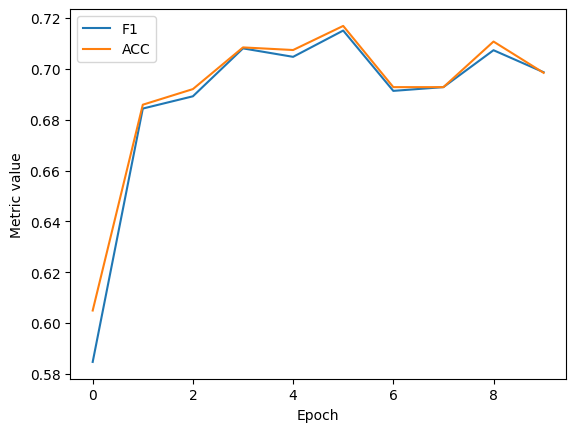

In [28]:
import matplotlib.pyplot as plt


plt.plot(ckp['f1_history'], label='F1')
plt.plot(ckp['acc_history'], label='ACC')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Metric value')

plt.show()

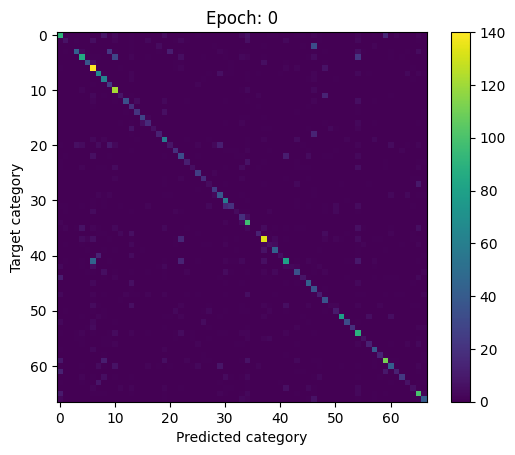

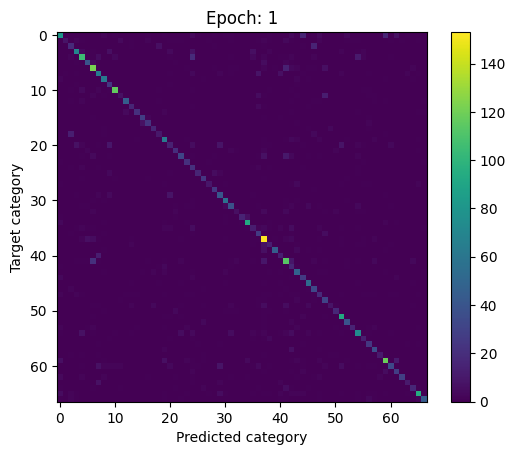

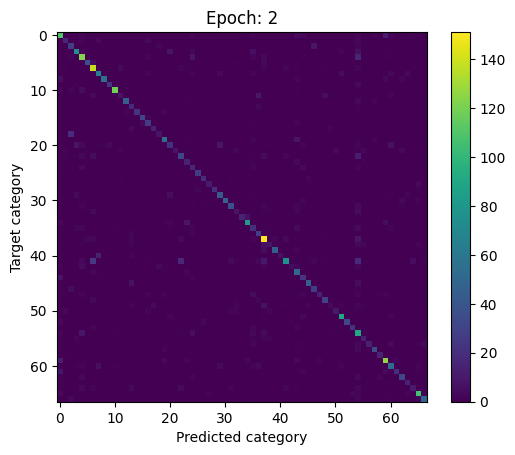

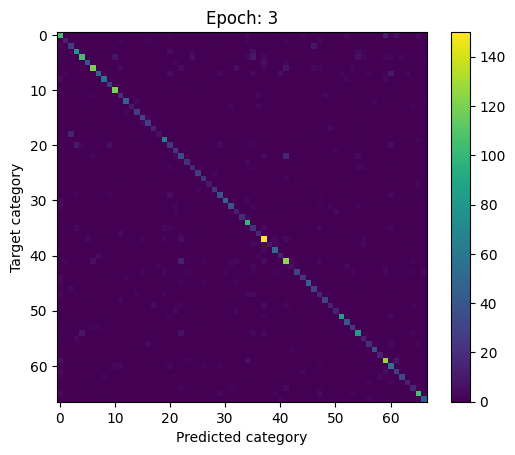

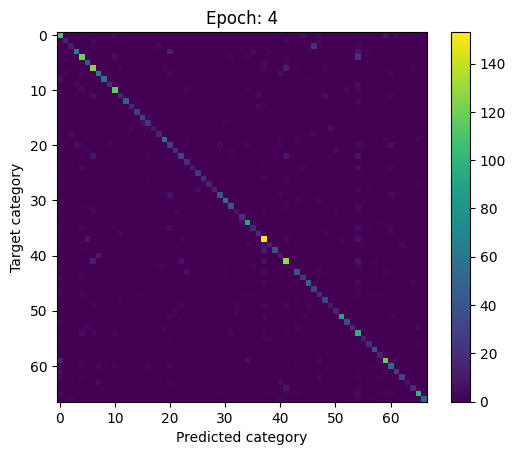

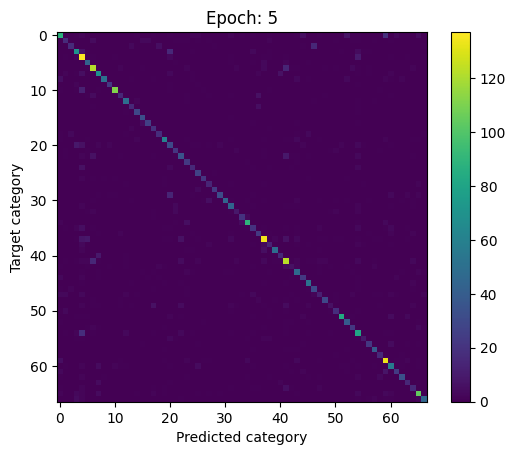

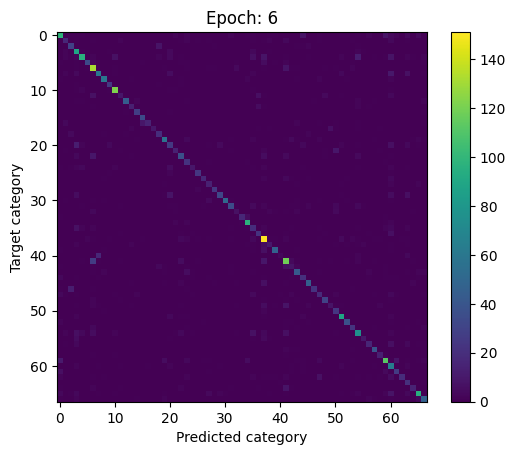

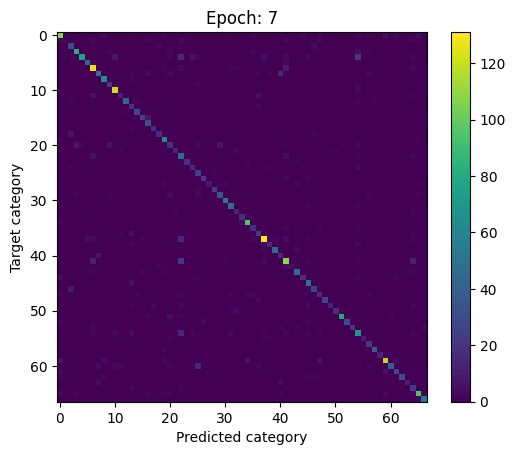

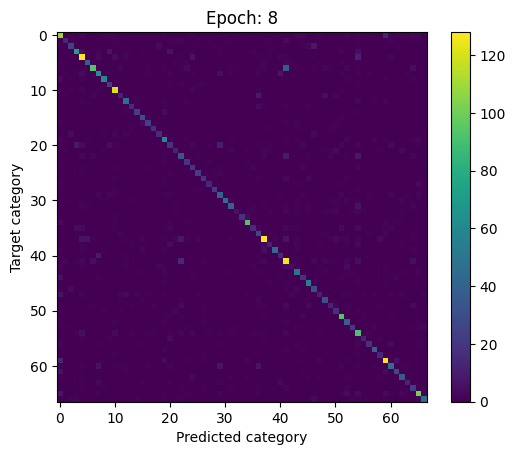

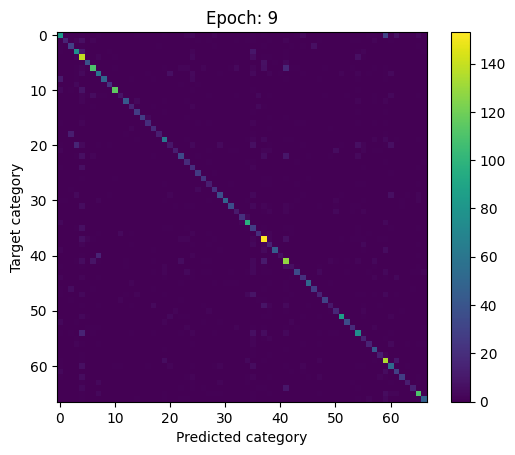

In [29]:
import matplotlib.pyplot as plt

for idx in range(len(ckp['cm_history'])):
  plt.imshow(ckp['cm_history'][idx], label='F1')

  plt.ylabel('Target category')
  plt.xlabel('Predicted category')

  plt.colorbar()
  plt.title(f'Epoch: {idx}')
  plt.show()